<a href="https://colab.research.google.com/github/nakata077/Forecasting-stock-price-/blob/main/NLP_tweets_disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

In [ ]:
pwd

'/content'

In [ ]:
#Import Data "Disaster Tweets"
train_df = pd.read_csv("/content/sample_data/train.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")
#the first 5 rows of our train DataFrame
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#data structure of the train data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
#Find Nan
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
#Find Nan
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [ ]:
# Removing location column since it will be not used in this project
train = train_df.drop(columns=['location'])
test = test_df.drop(columns=['location'])
train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# cleaning
import re

def cleantext(text):
  text = re.sub(r'https?://\S+','', text) # remove link
  text = re.sub(r'\n',' ', text) # Remove line breaks
  text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
  return text

# Extract hashtags, mentions, and links from each tweet in the DataFrame
# Add new collumns to our dataset

def find_hashtagds(tweet):
  return " ".join([match.group(0)[1:] for match in re.finditer(r"#\+", tweet)]) or 'no'

def find_mentions(tweet):
  return " ".join([match.group(0)[1:] for match in re.finditer(r"@\+", tweet)]) or 'no'

def find_links(tweet):
  return " ".join([match.group(0)[1:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
  df['text_clean'] = df['text'].apply(lambda x: cleantext(x))
  df['hashtags'] = df['text'].apply(lambda x: cleantext(x))
  df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
  df['links'] = df['text'].apply(lambda x: find_links(x))

  return df

train = process_text(train)
test = process_text(test)
#Our train dataset after process text operation
train.head(5)

,id,keyword,text,target,text_clean,hashtags,mentions,links
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,no,no
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,no,no
2,5,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,no,no
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",no,no
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,no,no


# **Add missing values in the "keyword" column**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.0 MB/s eta 0:00:00


In [ ]:
import transformers
import torch
# Instantiate the BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Instantiate the BERT model
model = transformers.BertModel.from_pretrained('bert-base-uncased')
def extract_keywords(text):
  tokens = tokenizer.encode(text, add_special_tokens=True)
  if len(tokens) == 0:
    return []
  input_ids = torch.tensor([tokens])
  with torch.no_grad():
    outputs = model(input_ids)
    embeddings = outputs.last_hidden_state[0]
  sentance_embedding = torch.sum(embeddings, dim=0)
  if len(sentance_embedding) < 3:
    # return fewer than 3 keywords if there aren't enough embeddings
    num_keywords = len(sentance_embedding)
  else:
    num_keywords = 3
  keywords = []
  for i in sentance_embedding.argsort()[-num_keywords:]:
    if i >= len(tokens):
      continue
    keywords.append(tokenizer.decode(tokens[i]))
  return keywords[::-1]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Fill in the missing values in the "keyword" column using BERT
for i in range(len(train)):
  if pd.isnull(train.loc[i, 'keyword']):
    keywords = extract_keywords(train.loc[i, 'text_clean'])
    train.loc[i, 'keyword'] = ', '.join(keywords)

for i in range(len(test)):
  if pd.isnull(test.loc[i, 'keyword']):
    keywords = extract_keywords(test.loc[i, 'text_clean'])
    test.loc[i, 'keyword'] = ', '.join(keywords)

In [ ]:
train.head(5)

,id,keyword,text,target,text_clean,hashtags,mentions,links
0,1,o f,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,no,no
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,no,no
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,no,no
3,6,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",no,no
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,no,no


In [ ]:
#Get the number of null values for each column
train.isnull().sum()

id            0
keyword       0
text          0
target        0
text_clean    0
hashtags      0
mentions      0
links         0
dtype: int64

# **Data visualization**

0    4342
1    3271
Name: target, dtype: int64


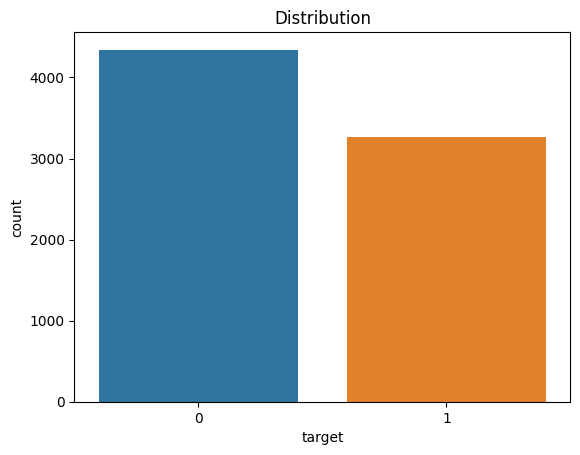

In [ ]:
#Visualization of the frequency distribution of the 'target' variable
sns.countplot(x='target', data=train)
plt.title('Distribution');

print(train['target'].value_counts())

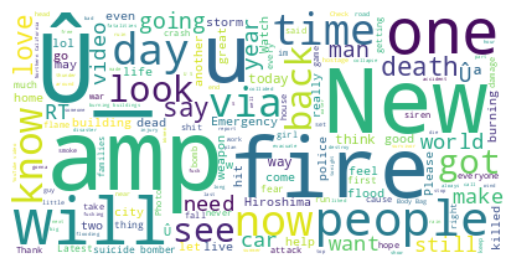

In [ ]:
#The creation of word clouds - visual representations of text data 
#in which the size of each word corresponds to its frequency in the input text.

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

# Combine all tweets into a single string
text = " ".join(tweet for tweet in train.text_clean)

# Create and generate a word cloud image
wordcloud = WordCloud(max_font_size=80, max_words=160, background_color="white").generate(text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

230 226


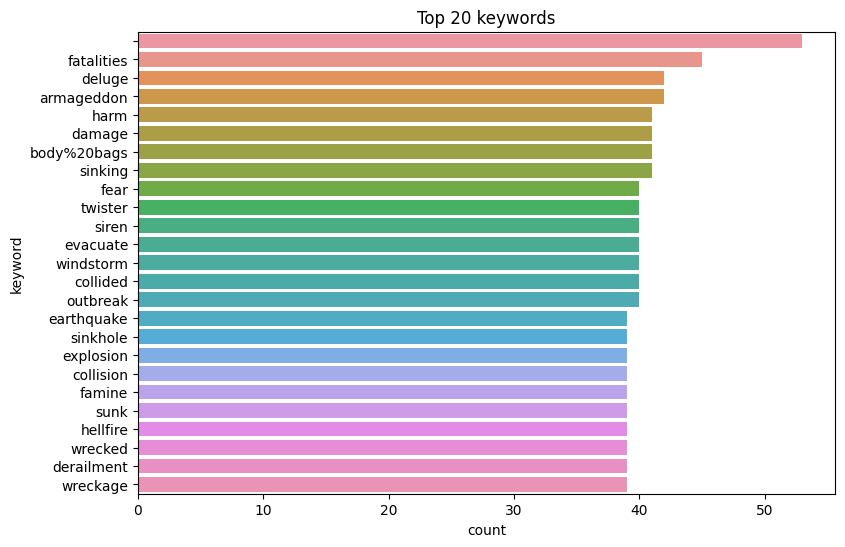

In [ ]:
# Check number of unique keywords, and whether they are the same for train and test sets
print (train.keyword.nunique(), test.keyword.nunique())
#print (set(train.keyword.unique()) - set(test.keyword.unique()))

# Most common keywords
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:25].index)
plt.title('Top 20 keywords')
plt.show()

In [ ]:
# Find top 50 kayword in disater tweet
import nltk
nltk.download('punkt')
from nltk import FreqDist, word_tokenize
#ltk.download('punkt')

# Make a set of stop words
stopwords = set(STOPWORDS)

keyword_freq = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'keyword']).lower()) if
(w not in stopwords) & (w.isalpha()))

keyword_word_freq = pd.DataFrame.from_dict(keyword_freq, orient='index', columns=['count'])
topkeyword = keyword_word_freq.sort_values('count',ascending=False).head(50)
list_topkeyword = topkeyword.iloc[0:50].index
list_topkeyword

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Index(['suicide', 'buildings', 'mass', 'emergency', 'nuclear', 'forest',
       'derailment', 'wreckage', 'outbreak', 'debris', 'oil', 'typhoon',
       'fire', 'evacuated', 'rescuers', 'razed', 'burning', 'earthquake',
       'airplane', 'bridge', 'collision', 'wildfire', 'casualties',
       'sandstorm', 'evacuation', 'drought', 'bombing', 'hostages',
       'devastation', 'wild', 'sinkhole', 'displaced', 'wounded', 'derailed',
       'violent', 'deaths', 'famine', 'fatal', 'fatalities', 'floods',
       'thunderstorm', 'massacre', 'heat', 'flooding', 'evacuate', 'attack',
       'injured', 'dust', 'terrorism', 'accident'],
      dtype='object')

# **Add new features**

In [ ]:
from wordcloud import STOPWORDS

def create_stat(df):
  # Tweet length
  df['text_len'] = df['text_clean'].apply(len)
  # Word count
  df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
  # Stopword count
  df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
  # Count of hashtags (#)
  df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
  # Punctuation count
  df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
  # Count of mentions (@)
  df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
  # Count of links
  df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
  # Count of uppercase letters
  df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
  # Ratio of uppercase letters
  df['caps_ratio'] = df['caps_count'] / df['text_len']
  # Number of keyword occuring in tweet
  df['num_keyword'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_topkeyword ]))

  return df

train = create_stat(train)
test = create_stat(test)

train.head(5)

,id,keyword,text,target,text_clean,hashtags,mentions,links,num_keyword,text_len,word_count,stop_word_count,hashtag_count,punctuation_count,mention_count,link_count,caps_count,caps_ratio
0,1,o f,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,no,no,0,69,13,6,13,1,1,1,10,0.144928
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,no,no,2,38,7,0,7,1,1,1,5,0.131579
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,no,no,1,133,22,11,22,3,1,1,2,0.015038
3,6,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",no,no,1,64,8,1,8,2,1,1,1,0.015625
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,no,no,0,87,16,7,16,2,1,1,3,0.034483


# **Find inportance of features**

In [ ]:
#split train test
from sklearn.model_selection import train_test_split

X = train[['num_keyword','text_len','word_count','stop_word_count','hashtag_count','punctuation_count','mention_count','link_count','caps_count','caps_ratio']]
y = train[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

y_train.head(5)

,target
476,0
4854,1
4270,0
992,0
4475,1


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


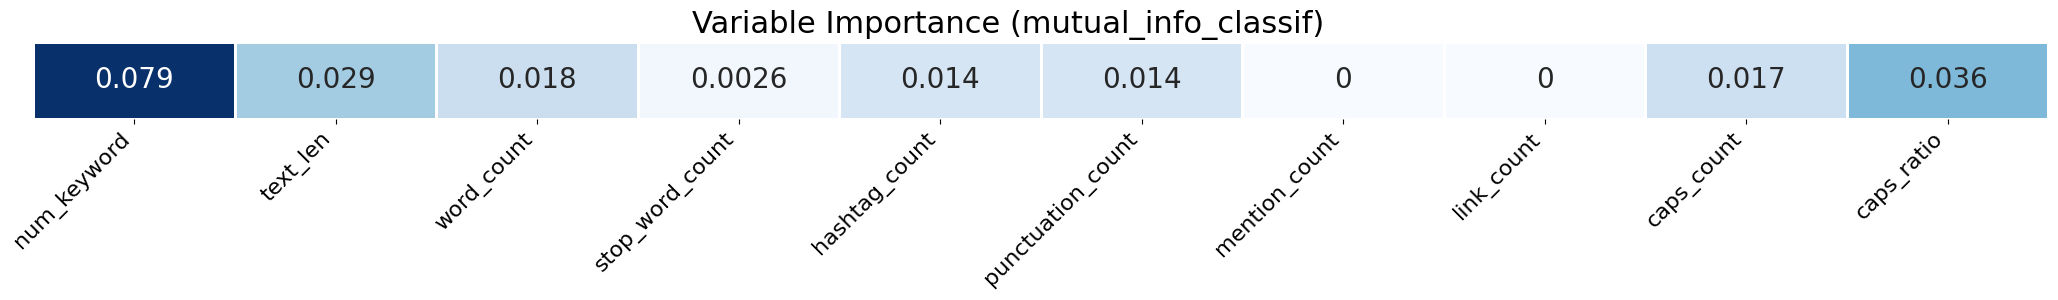

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_information = mutual_info_classif(X_train, y_train, n_neighbors=5, copy = True)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True, annot_kws={"size": 20})
plt.yticks([], [])
plt.gca().set_xticklabels(X_train.columns, rotation=45, ha='right', fontsize=16)
plt.suptitle("Variable Importance (mutual_info_classif)", fontsize=22, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)

<ipython-input-62-19b17fe19258>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


Text(0.5, 0, 'Relative Importance')

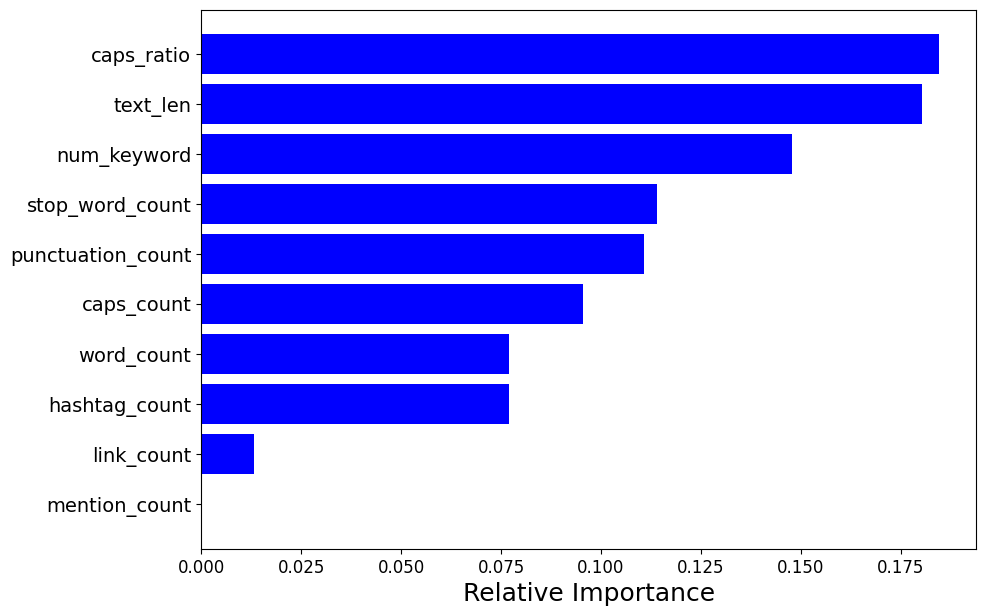

In [ ]:
# plot important feature 
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)

features = list(X_train.columns)
importances = rf_clf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 7))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=14)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontsize = 18)

# **Find the most frequently occurring words**


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


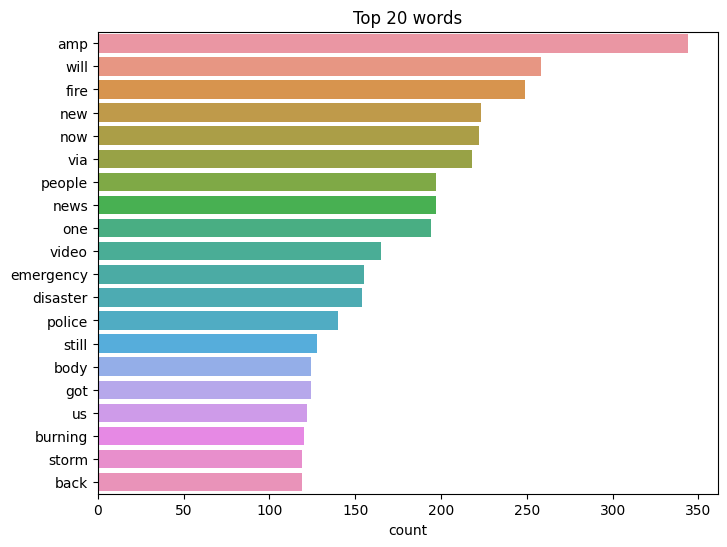

In [ ]:
import nltk
nltk.download('punkt')
from nltk import FreqDist, word_tokenize
#ltk.download('punkt')

# Make a set of stop words
stopwords = set(STOPWORDS)

# Calculation of the frequency distribution of unigrams (single words) 
# in the "text_clean" column of the "train" dataset
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))

#Creation a DataFrame from the frequency distribution and selects the top 20 most common words
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

#Creation a bar plot of the top 20 words using the Seaborn library
plt.figure(figsize=(8,6))
sns.barplot(x='count', y=top20w.index, data=top20w)
plt.title('Top 20 words')
plt.show()

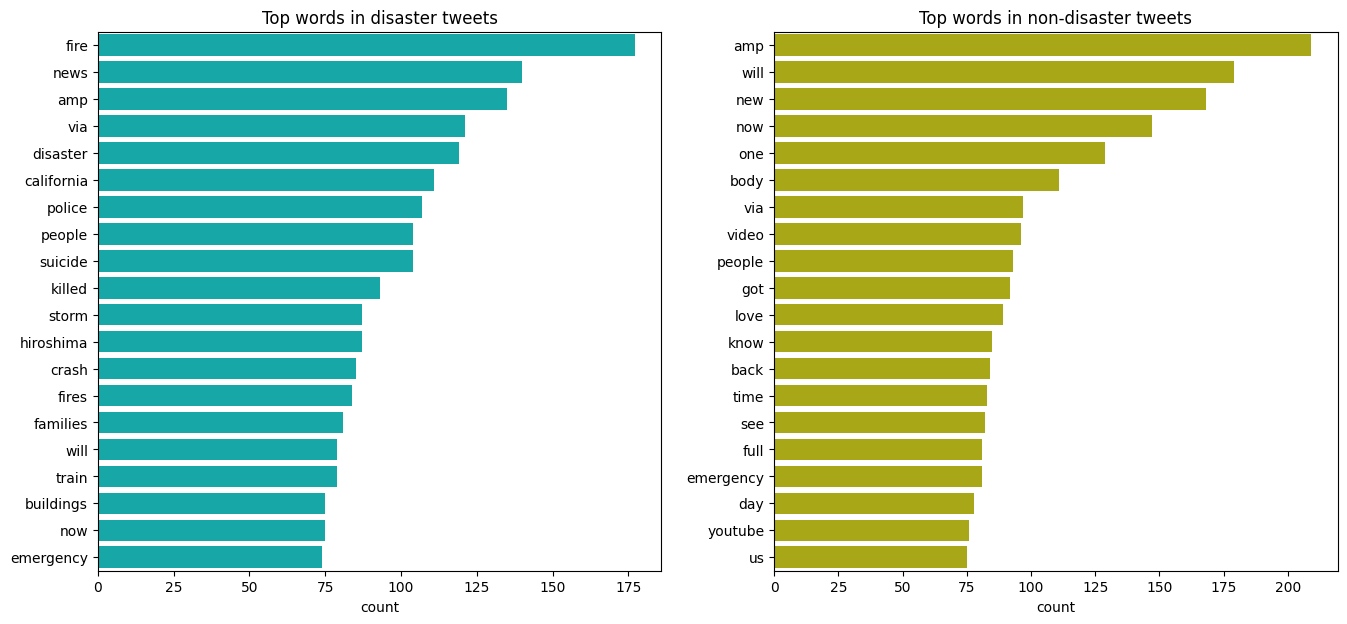

In [ ]:
### This code creates a figure with two subplots, each showing the top 20 most frequent words in disaster and non-disaster tweets, respectively.
plt.figure(figsize=(16,7))

#The first subplot
plt.subplot(121)

#Tokenize the words in the "text_clean" column of the "train" dataset for disaster tweets and calculate the frequency distribution of unigrams
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if
(w not in stopwords) & (w.isalpha()))

#Convert the frequency distribution into a DataFrame
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])

#Select the top 20 most frequent words
top20_d = df_d.sort_values('count',ascending=False).head(20)

#Create a bar plot of the top 20 words, where the x-axis represents the frequency count and the y-axis represents the words.
sns.barplot(x='count', y=top20_d.index, data=top20_d, color='c')

#Set the title of the first subplot
plt.title('Top words in disaster tweets')

#The second subplot
plt.subplot(122)

#Tokenize the words in the "text_clean" column of the "train" dataset for non-disaster tweets and calculate the frequency distribution of unigrams
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if
(w not in stopwords) & (w.isalpha()))

#Convert the frequency distribution into a DataFrame
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])

#Select the top 20 most frequent words
top20_nd = df_nd.sort_values('count',ascending=False).head(20)

#Create a bar plot of the top 20 words, where the x-axis represents the frequency count and the y-axis represents the words.
sns.barplot(x='count', y=top20_nd.index, data=top20_nd, color='y')

#Set the title of the second subplot
plt.title('Top words in non-disaster tweets')

#Display the plot
plt.show()

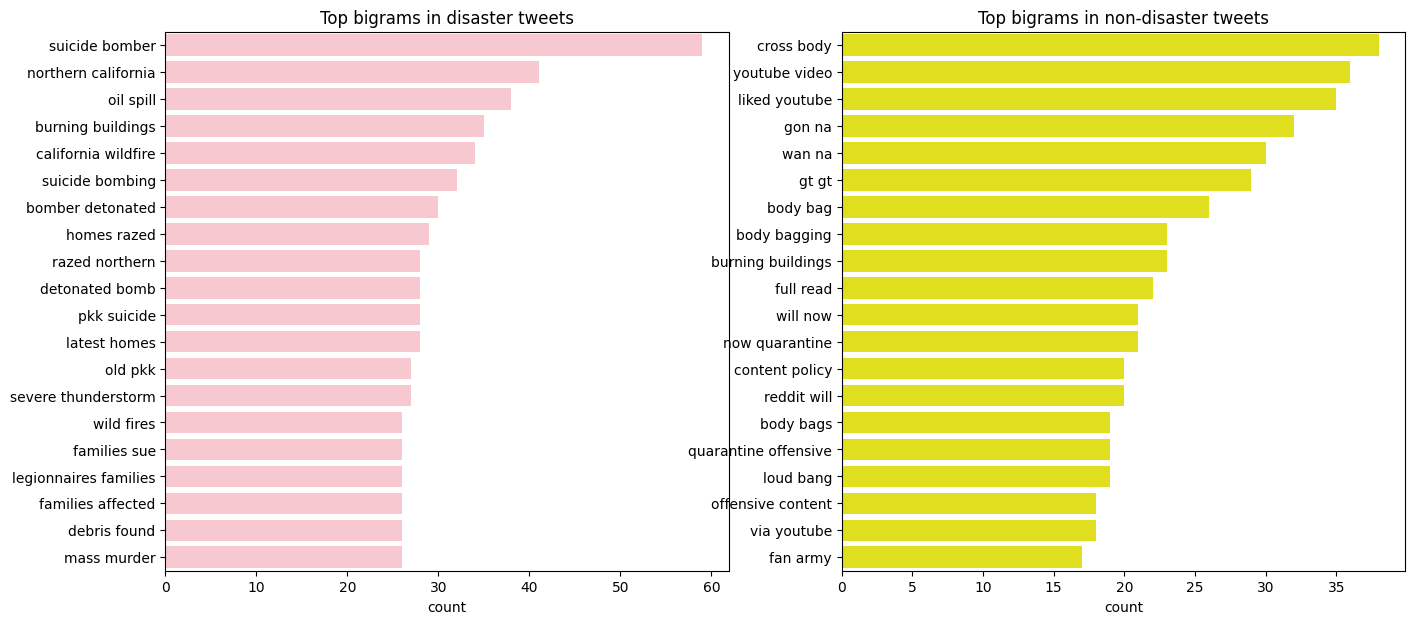

In [ ]:
# Import the required libraries
from nltk import bigrams # For generating bigrams

# Set the figure size for the plot
plt.figure(figsize=(16,7))

# Create a subplot for the first graph
plt.subplot(121)

# Generate bigrams from the 'text_clean' column of disaster tweets
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))

# Calculate the frequency distribution of the bigrams
d_fq = FreqDist(bg for bg in bigram_d)

# Convert the frequency distribution to a dataframe
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])

# Join the bigram words with a space in between
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))

# Sort the bigrams by their frequency in descending order
bgdf_d = bgdf_d.sort_values('count',ascending=False)

# Create a barplot of the top 20 bigrams in disaster tweets
sns.barplot(x=bgdf_d.head(20)['count'], y=bgdf_d.index[:20], color='pink')

# Set the title for the subplot
plt.title('Top bigrams in disaster tweets')

# Create a subplot for the second graph
plt.subplot(122)

# Generate bigrams from the 'text_clean' column of non-disaster tweets
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))

# Calculate the frequency distribution of the bigrams
nd_fq = FreqDist(bg for bg in bigram_nd)

# Convert the frequency distribution to a dataframe
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])

# Join the bigram words with a space in between
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))

# Sort the bigrams by their frequency in descending order
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)

# Create a barplot of the top 20 bigrams in non-disaster tweets
sns.barplot(x=bgdf_nd.head(20)['count'], y=bgdf_nd.index[:20], color='yellow')

# Set the title for the subplot
plt.title('Top bigrams in non-disaster tweets')

# Show the plot
plt.show()

# **Encoding and Vectorizers**

In [ ]:
!pip install category_encoders
import category_encoders as ce

# Target encoding
# Specify the column(s) to encode
features = ['keyword']

# Create a target encoder object
encoder = ce.TargetEncoder(cols=features)

# Fit the encoder on the training set
encoder.fit(train[features], train['target'])

# Apply the encoding to both the training and test sets and add suffix "_target" to the new columns
train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))
train.head(5)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.6 MB/s eta 0:00:00


,id,keyword,text,target,text_clean,hashtags,mentions,links,num_keyword,text_len,word_count,stop_word_count,hashtag_count,punctuation_count,mention_count,link_count,caps_count,caps_ratio,keyword_target
0,1,o f,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,no,no,0,69,13,6,13,1,1,1,10,0.144928,0.503866
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,no,no,2,38,7,0,7,1,1,1,5,0.131579,0.652170
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,no,no,1,133,22,11,22,3,1,1,2,0.015038,0.652170
3,6,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",no,no,1,64,8,1,8,2,1,1,1,0.015625,0.652170
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,no,no,0,87,16,7,16,2,1,1,3,0.034483,0.652170


In [ ]:
train['links']

0                          no
1                          no
2                          no
3                          no
4                          no
                ...          
7608    ttp://t.co/STfMbbZFB5
7609                       no
7610    ttp://t.co/zDtoyd8EbJ
7611                       no
7612    ttp://t.co/YmY4rSkQ3d
Name: links, Length: 7613, dtype: object

In [ ]:
#split train test
from sklearn.model_selection import train_test_split

X = train[['num_keyword','text_len','word_count','stop_word_count','hashtag_count','punctuation_count','mention_count','link_count','caps_count','caps_ratio','keyword_target']]
y = train[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

y_train.head(5)

,target
476,0
4854,1
4270,0
992,0
4475,1


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


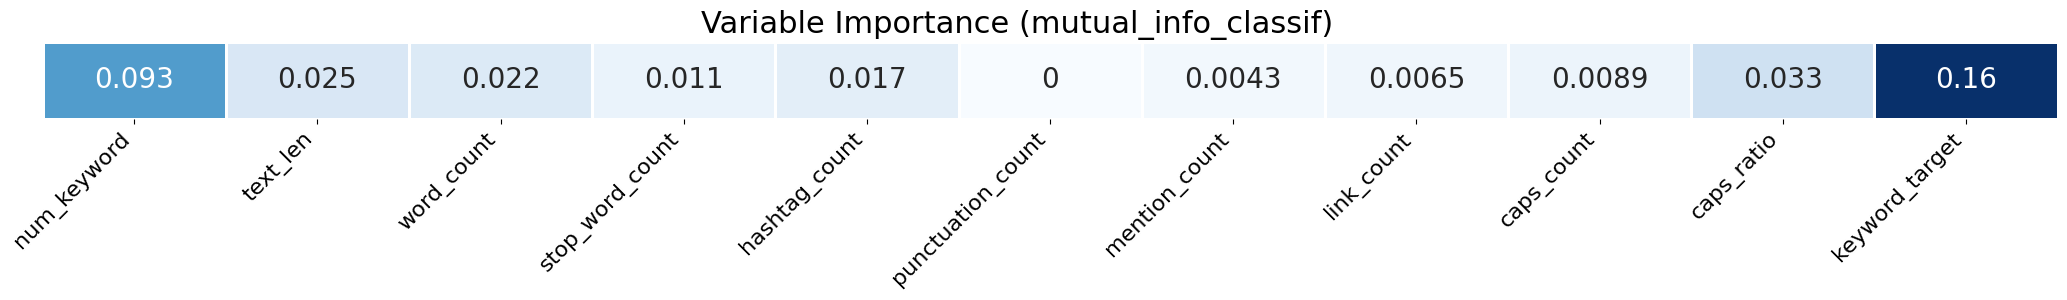

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_information = mutual_info_classif(X_train, y_train, n_neighbors=5, copy = True)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True, annot_kws={"size": 20})
plt.yticks([], [])
plt.gca().set_xticklabels(X_train.columns, rotation=45, ha='right', fontsize=16)
plt.suptitle("Variable Importance (mutual_info_classif)", fontsize=22, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)

<ipython-input-70-19b17fe19258>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


Text(0.5, 0, 'Relative Importance')

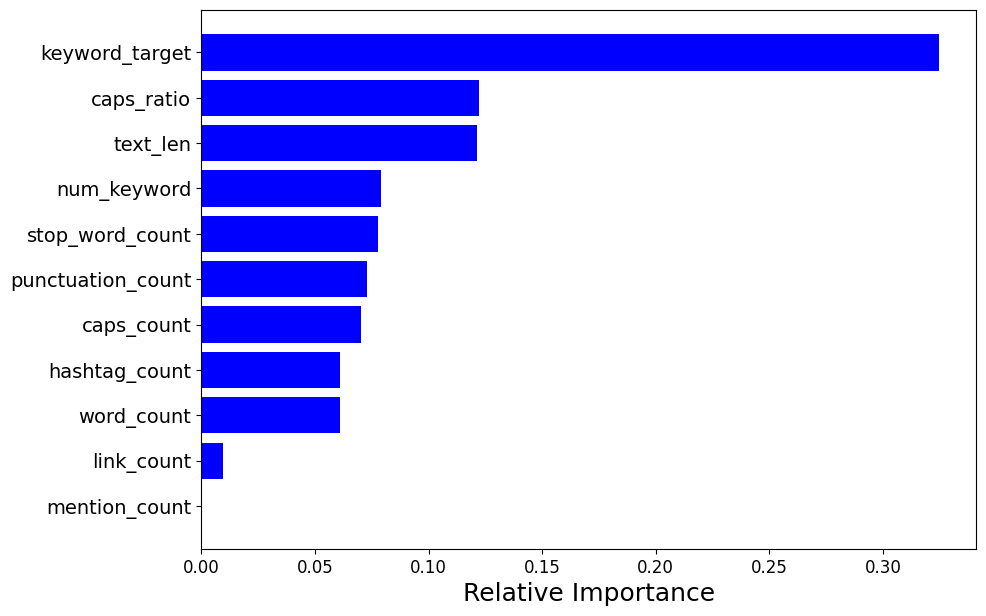

In [ ]:
# plot important feature 
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)

features = list(X_train.columns)
importances = rf_clf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 7))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=14)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontsize = 18)

# **Machine learning models**

In [ ]:
train.head(3)

,id,keyword,text,target,text_clean,hashtags,mentions,links,num_keyword,text_len,word_count,stop_word_count,hashtag_count,punctuation_count,mention_count,link_count,caps_count,caps_ratio,keyword_target
0,1,o f,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,no,no,0,69,13,6,13,1,1,1,10,0.144928,0.503866
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,no,no,2,38,7,0,7,1,1,1,5,0.131579,0.652170
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,no,no,1,133,22,11,22,3,1,1,2,0.015038,0.652170


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler to normalize the features
scaler = MinMaxScaler()

feature = ['num_keyword','text_len','word_count','stop_word_count','hashtag_count','punctuation_count','mention_count','link_count','caps_count','caps_ratio','keyword_target']
f2 = ['num_keyword','text_len','caps_ratio','keyword_target']
# Separate the target variable from the training dataset
X_train = train[f2]
y_train = train['target']

# Get the testing dataset and remove the features that were dropped from the training dataset
X_test = test[f2]

# Initialize a logistic regression model
lr = LogisticRegression(solver='liblinear', random_state=777)

# Create a pipeline that scales the features and trains the logistic regression model
pipeline = Pipeline([('scale',scaler), ('lr', lr)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Use the pipeline to make predictions on the testing data
y_test = pipeline.predict(X_test)

print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

Training accuracy: 0.7454


In [ ]:
# sequential model to initialise our ann and dense module to build the layers
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 4))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

762/762 [==============================] - 2s 2ms/step - loss: 0.5098 - accuracy: 0.7561
Train score: 0.5098096132278442
Train accuracy: 0.7560751438140869


In [ ]:
from sklearn.metrics import accuracy_score

#ML models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Try Ensemble of Models 
LR = LogisticRegression(multi_class='multinomial', random_state=1)
RF = RandomForestClassifier(n_estimators=50, random_state=1)
XGB = XGBClassifier()

hard_voting = VotingClassifier(estimators=[('lr', LR), ('rf', RF), ('xgb', XGB)], voting='hard')

# Voting Classifier with hard voting 
hard_voting.fit(X_train, y_train) 
y_predict = hard_voting.predict(X_test)

# accuracy_score metric to predict Accuracy 
score = accuracy_score(y_test, y_predict) 
print("softVoting Score % d" % score) 

softVoting Score  0


In [ ]:
print(f"{round(score*100,2)}% Accurate")

d = {'Answer': y_test, 'y_predict': y_predict}
hard_voting_decision = pd.DataFrame(data=d)
hard_voting_decision.head(5)

90.68% Accurate


,Answer,y_predict
0,0,0
1,1,1
2,1,1
3,1,0
4,1,1
